In [2]:
from reweight_functions import *
import pickle

In [3]:
datadir = './'

outdir = os.path.join(datadir, 'reweight')

weights_dir = os.path.join(outdir, 'weights')

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

single_dir = os.path.join(weights_dir + "/single_data")
if not os.path.exists(single_dir):
    os.makedirs(single_dir)
leave_dir = os.path.join(weights_dir + "/leave_one_data")
if not os.path.exists(leave_dir):
    os.makedirs(leave_dir)
combined_dir = os.path.join(weights_dir + "/combined_data")
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

dic_dir = os.path.join(outdir, 'dictionaries')
if not os.path.exists(dic_dir):
    os.makedirs(dic_dir)

In [4]:

chemical_shifts = ['CB', 'HA', 'CA', 'H', 'N']

colors = {'C': 'royalblue', 'HA': 'orange', 'CA': 'red', 'CB': 'forestgreen', 'H': 'mediumorchid',
            'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'SAXS': 'teal',
            'Tot': 'black'}

reweighting_keys = ['CA', 'CB', 'H', 'N']
theta_0 = {'HA': 1., 'CA': 1, 'CB': 1., 'C': 1., 'H': 1., 'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1.,
            'JHNHA': 1., 'SAXS': 1.}

to_remove = ['HA2', 'HA3', 'C', 'HA']

print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))

Main settings:

Reweighting keys: ['CA', 'CB', 'H', 'N']


In [5]:
# chemical shifts
expdata = read_exp_cs(join(datadir, 'CS.exp.dat')) # try without thr4 
compdata = read_cs_md(join(datadir, 'cs_assignment.csv'), )



# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)

####### TRAJ-related quantities

nframes = len(compdata[list(compdata.keys())[1]][list(compdata[list(compdata.keys())[1]].keys())[0]])
# nframes = len(compdata['Rg'][0])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove]

print(
    'Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format(
        [str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N']
Number of frames = 41499


In [6]:
sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    # i) Process Reweight data into arrays 
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_r)

    # ii) Process Validation data into arrays 
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_v)

    # final_weights

    for key in data_v_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries = compare_dict_v[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_v[key][key2][0]), float(ave), float(sigma)])

    for key in data_r_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries = compare_dict_r[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_r[key][key2][0]), float(ave), float(sigma)])

Reweight Data = CA
Validation Data = ['CB', 'H', 'N']
CB
H
N
CA
Reweight Data = CB
Validation Data = ['CA', 'H', 'N']
CA
H
N
CB
Reweight Data = H
Validation Data = ['CA', 'CB', 'N']
CA
CB
N
H
Reweight Data = N
Validation Data = ['CA', 'CB', 'H']
CA
CB
H
N


In [7]:
To_Scan = reweighting_keys
thetas = np.linspace(0.001, 20, 200)
ref_theta = thetas[-1]
RMSE_dict = {}
KishScan_one_data = {}


for CS in To_Scan:
        CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
        KishScan_one_data[CS] = {}
        print('Reweight Data = {}'.format(CS))
        RMSE_dict[CS] = {}

        ### debugging variables
        compare = []
        compare_dict_r = {key: {} for key in compdata.keys()}
        compare_dict_v = {key: {} for key in compdata.keys()}

        ####### B) The reweighting procedure

        obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
            Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
        obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
            Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

        # THETA CYCLE
        theta_list = []
        kish_list = []
        rmsd_f_list = []
        for theta_m in np.flip(thetas):

            s = '{:.2f}'.format(theta_m)
            # print(s)
            sigma_reg = theta_m * err_r
            sigma_md = sigma_md_r
            RMSE_dict[CS][s] = {}

            # iv) Print dimensions
            nobs_r = len(obs_exp_r)
            nobs_v = len(obs_exp_v)
            # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

            # v) perform minimization
            # OBS: res.X = lagrange multiplier
            weight_bias = np.ones(nframes)

            if 'RDC' in Reweight_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_r = np.dot(traj_r, initial_weights)
                initial_obs_r
                exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_r_type['RDC'] == 1)
                traj_r[RDC_rows] = traj_r[RDC_rows] * c

            if 'RDC' in Validation_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_v = np.dot(traj_v, initial_weights)
                exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_v_type['RDC'] == 1)
                traj_v[RDC_rows] = traj_v[RDC_rows] * c

            res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                       args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                       x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
            initial_weights = Normalize_Weights(weight_bias)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)

            final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
            final_obs_r = np.dot(traj_r, final_weights)
            final_obs_v = np.dot(traj_v, final_weights)
            # g) calculating Kish effective size
            Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
            Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

            Kish_ratio = (Ks_a / Ks_b) * 100
            RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
            RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            theta_list.append(theta_m)
            kish_list.append(Kish_ratio)
            rmsd_f_list.append(RMSE_reweight)
            RMSE_r_i = {}
            RMSE_v_i = {}
            RMSE_r_f = {}
            RMSE_v_f = {}
            RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_i[t] = np.sqrt(
                    np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_i['RDC'] = qf

            RMSE_v_i['Tot'] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            for t in data_v_type:
                RMSE_v_i[t] = np.sqrt(
                    np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_i['RDC'] = qf

            RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_f['RDC'] = qf

            for t in data_v_type:
                RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_f['RDC'] = qf

            RMSE_dict[CS][s]['Kish'] = Kish_ratio
            RMSE_dict[CS][s]['r_i'] = RMSE_r_i
            RMSE_dict[CS][s]['r_f'] = RMSE_r_f
            RMSE_dict[CS][s]['v_i'] = RMSE_v_i
            RMSE_dict[CS][s]['v_f'] = RMSE_v_f

        KishScan_one_data[CS]['kish'] = np.column_stack((theta_list, kish_list))
        KishScan_one_data[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA
Reweight Data = CB
Reweight Data = H
Reweight Data = N


In [8]:
kish_min = 10
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan_one_data:
    k = KishScan_one_data[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict[key] = {}
    theta_dict[key] = (theta_m)


In [9]:
def print_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
  
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
 
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
           
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)


In [10]:
To_Scan = reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(single_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m
    sigma_md = sigma_md_r


    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
    print_results()

   
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()


Reweight Data = CA
1.31
CA Theta: 1.3074673366834169 Kish: 10.645346 RMSD initail: 0.7588 RMSD final: 0.3787
Initial RMSE reweight data 
 * Total :      0.759
 *    CA :      0.759
Initial RMSE validation data
 * Total :      1.084
 *    CB :      0.565
 *     H :      0.213
 *     N :      1.770
Final RMSE reweight data
 * Total :      0.379
 *    CA :      0.379
Final RMSE validation data
 * Total :      0.921
 *    CB :      0.427
 *     H :      0.155
 *     N :      1.523
Reweight Data = CB
1.01
CB Theta: 1.005974874371859 Kish: 12.123909 RMSD initail: 0.5653 RMSD final: 0.2749
Initial RMSE reweight data 
 * Total :      0.565
 *    CB :      0.565
Initial RMSE validation data
 * Total :      1.116
 *    CA :      0.759
 *     H :      0.213
 *     N :      1.770
Final RMSE reweight data
 * Total :      0.275
 *    CB :      0.275
Final RMSE validation data
 * Total :      0.978
 *    CA :      0.593
 *     H :      0.173
 *     N :      1.583
Reweight Data = H
0.40
H Theta: 0.402

In [11]:
combined_reweighting_keys = [reweighting_keys]
print('Reweighting keys: {}'.format(combined_reweighting_keys))

To_Scan = combined_reweighting_keys
thetas = np.linspace(0.01, 15, 40)
ref_theta = thetas[-1]
RMSE_dict_combined = {}
KishScan_combined = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_combined[CS] = {}
    CS_dir = join(combined_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    print('Reweight Data = {}'.format(CS))
    RMSE_dict_combined[CS] = {}
    combined_key_string = CS

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        print(s)
        sigma_reg = theta_m * err_r
        #sigma_md = sigma_md_r
        sigma_md = np.zeros(len(sigma_md_r))
        RMSE_dict_combined[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)
        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        # if res.success: print("\nMinimization worked: {}\n".format(res.success))
        # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        # e) final average observables for reweighting and validation
        final_obs_r = np.dot(traj_r, final_weights)

        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        # print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_r_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        RMSE_dict_combined[CS][s]['Kish'] = Kish_ratio
        RMSE_dict_combined[CS][s]['r_i'] = RMSE_r_i
        RMSE_dict_combined[CS][s]['r_f'] = RMSE_r_f
    KishScan_combined[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_combined[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweighting keys: [['CA', 'CB', 'H', 'N']]
Reweight Data = CA-CB-H-N
15.00
14.62
14.23
13.85
13.46
13.08
12.69
12.31
11.93
11.54
11.16
10.77
10.39
10.00
9.62
9.23
8.85
8.47
8.08
7.70
7.31
6.93
6.54
6.16
5.78
5.39
5.01
4.62
4.24
3.85
3.47
3.08
2.70
2.32
1.93
1.55
1.16
0.78
0.39
0.01


In [12]:
kish_min = 10
theta_dict_combined = {}
Kish_ratio_vals = []
for key in KishScan_combined:
    k = KishScan_combined[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_combined[key] = {}
    theta_dict_combined[key] = (theta_m)
    print(key, theta_m)

CA-CB-H-N 1.9317948717948719


In [13]:
def print_comb_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
          "RMSD final: %0.4f" % RMSE_reweight)

    # Iniitial RMSE and Sigma
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print(
            "     %6.3lf" % np.sqrt(np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                               obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

In [14]:
PREs = ['PRE_24', 'PRE_42', 'PRE_62', 'PRE_87', 'PRE_103']
from matplotlib.ticker import StrMethodFormatter

def plot_fitting_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
    
            if t == 'RDC':
                qi_initial, rms_initial, qf_initial, rms_f_initial, rdc_scale_i_initial, c = scale_rdc_Q(exp, initial)
                qi_reweight, rms_i_reweight, qf_reweight, rms_f_reweight, rdc_scale_i_reweight, c = scale_rdc_Q(exp,
                                                                                                                reweight)
                print("RMSD initial scale:%6.3lf" % rms_f_initial, "RMSD final scale:%6.3lf" % rms_f_reweight)
                print("Q initial scale:%6.3lf" % qf_initial, "Q final scale:%6.3lf" % qf_reweight)
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', label="Reweighted", linestyle='dashed')
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel(r'$D_{N-HN}$(Hz)', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.grid()
                plt.xlabel('Residues', size=18)
                plt.legend( loc='upper right', fontsize=12)
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'SAXS':
                plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed' ,label="Reweighted")
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel('Peak Intensity', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.xlabel('Scattering angle (q)', size=18, labelpad=7)
                plt.legend(loc='upper right', fontsize=12)
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()
            elif t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.grid()
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                # save the reweighting data for CA - MG edit 
                np.savetxt('%s/%s.reweight.dev.dat' % (outdir, t), np.column_stack((np.column_stack((np.asarray(resid), np.absolute(initial - exp))),np.absolute(reweight - exp))))

                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'CB':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\beta$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.grid()
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'HA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"H$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.grid()
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == "JHNHA":
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$^3J_{calc}$- $^3J_{exp}$|', size=20)
                plt.title(r"$^3JHNH\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.grid()
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.png'%(outdir,t), bbox_inches='tight')
                plt.show()

            elif t in PREs:

                plt.plot(np.asarray(resid), initial, color='red', label='Unbiased')
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed', label='Reweighted')
                plt.plot(np.asarray(resid), exp, color='black', label='Experiment')
                plt.ylabel('Peak Intensity', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.grid()
                plt.xlabel('Residue', size=18)
                plt.legend(bbox_to_anchor=(1, 1.0), loc='upper left', fontsize=12)
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf'%(outdir,t), bbox_inches='tight')
                plt.show()



            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.grid()
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

CA
RMSD_initial: 0.759 RMSD_final: 0.468


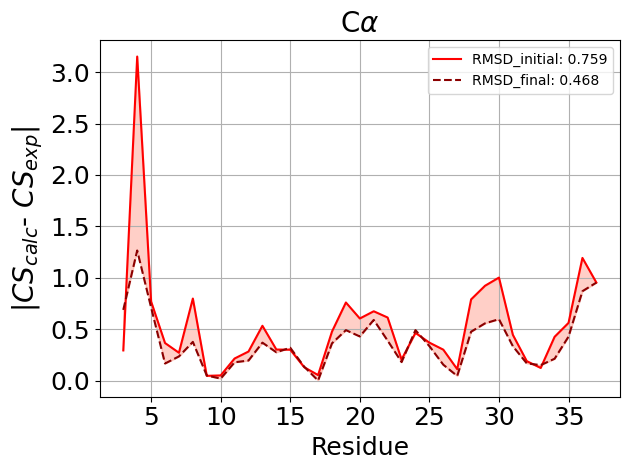

CB
RMSD_initial: 0.565 RMSD_final: 0.351


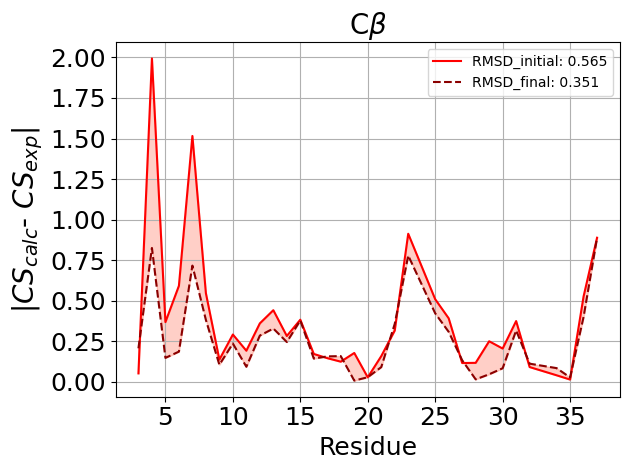

H
RMSD_initial: 0.213 RMSD_final: 0.140


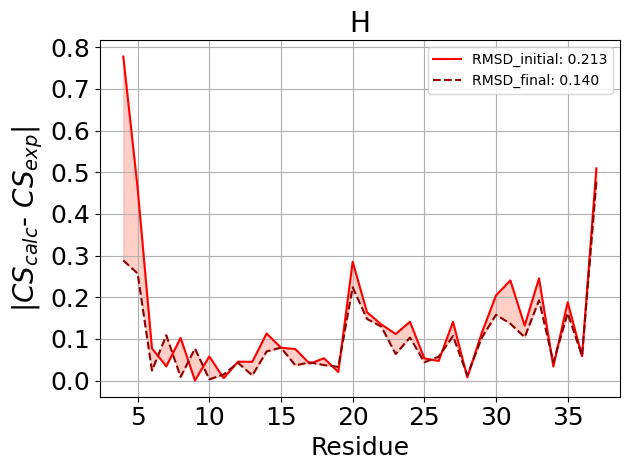

N
RMSD_initial: 1.770 RMSD_final: 1.327


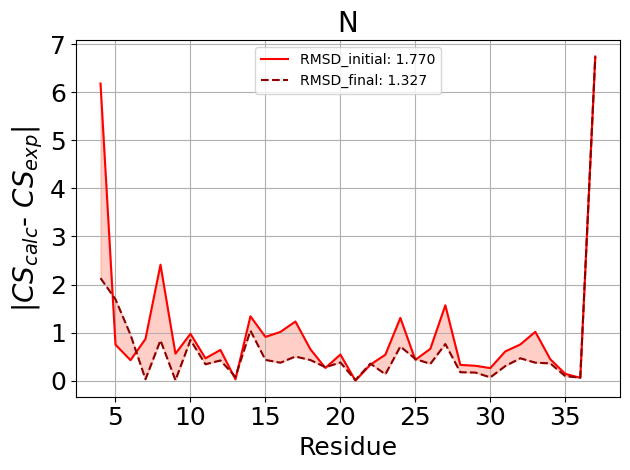

CA-CB-H-N Theta: 1.9317948717948719 Kish: 10.437021 RMSD initail: 1.0103 RMSD final: 0.7287
Initial RMSE reweight data 
 * Total :      1.010
 *    CA :      0.759
 *    CB :      0.565
 *     H :      0.213
 *     N :      1.770
Final RMSE reweight data
 * Total :      0.729
 *    CA :      0.468
 *    CB :      0.351
 *     H :      0.140
 *     N :      1.327


In [15]:
To_Scan=combined_reweighting_keys


CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


s = '{:.2f}'.format(theta_m)

sigma_reg=theta_m*err_r
sigma_md=sigma_md_r
# sigma_md = np.zeros(len(sigma_md_r))

        

nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

plot_fitting_data(final_weights)
print_comb_results()

np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# print final weights to file

f = open("%s/weights_final.a.dat" % CS_dir, "w")
for w in final_weights:
       f.write("%e\n" % w)
f.close()

In [16]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [17]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1
 dsspH[dsspH=='E']=0
 dsspH[dsspH=='C']=0
 dsspH[dsspH=='NA']=0
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1)
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspH[:,i].astype(float)
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5]

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1)
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E

In [18]:
def block(x):
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    for i in arange(0,d):
        n = len(x)
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        s[i] = var(x)
        x = 0.5*(x[0::2] + x[1::2])

    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

In [19]:
pdb = '/Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/wt_hiapp_reweight/hiapp_wt_apo.gro'
trajectory = '/Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/outdir_wt_hiapp_apo/hiapp_wt_apo_300k.xtc'
outdir = '/Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/wt_hiapp_reweight/reweight/ensembles/'
weight_file = '/Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/wt_hiapp_reweight/reweight/weights/combined_data/CA-CB-H-N/weights_final.dat'
weights=np.loadtxt(weight_file)

if not os.path.exists(outdir):
    os.makedirs(outdir)


print("outdir",outdir)
print("pdb",pdb)
print("trajectory",trajectory)
print("weights_file",weight_file)

outdir /Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/wt_hiapp_reweight/reweight/ensembles/
pdb /Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/wt_hiapp_reweight/hiapp_wt_apo.gro
trajectory /Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/outdir_wt_hiapp_apo/hiapp_wt_apo_300k.xtc
weights_file /Users/f006j60/git/hIAPP_monomer_simulations/wt_hiapp_apo/wt_hiapp_reweight/reweight/weights/combined_data/CA-CB-H-N/weights_final.dat


In [20]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
trj = trj[1:]
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [21]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

In [22]:
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 537

Number of residues: 38

Number of protein residues: 37

Number of frames: 41500

Starting frame: 0

Last frame: 41500

sequence:  [LYS1, CYS2, ASN3, THR4, ALA5, THR6, CYS7, ALA8, THR9, GLN10, ARG11, LEU12, ALA13, ASN14, PHE15, LEU16, VAL17, HIS18, SER19, SER20, ASN21, ASN22, PHE23, GLY24, ALA25, ILE26, LEU27, SER28, SER29, THR30, ASN31, VAL32, GLY33, SER34, ASN35, THR36, TYR37, NH238]

residue names:  ['LYS', 'CYS', 'ASN', 'THR', 'ALA', 'THR', 'CYS', 'ALA', 'THR', 'GLN', 'ARG', 'LEU', 'ALA', 'ASN', 'PHE', 'LEU', 'VAL', 'HIS', 'SER', 'SER', 'ASN', 'ASN', 'PHE', 'GLY', 'ALA', 'ILE', 'LEU', 'SER', 'SER', 'THR', 'ASN', 'VAL', 'GLY', 'SER', 'ASN', 'THR', 'TYR', 'NH2']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]



In [23]:
residue_offset=0
prot_res_renum=np.asarray(prot_res)+residue_offset
residue_number = range(0,residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

Residue Number Range: range(0, 37)


In [24]:
dssp=md.compute_dssp(trj, simplified=True)
np.savetxt(outdir+"/dssp.out",dssp,fmt='%s')
H1_H,H1_E=dssp_convert(dssp)

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_5452/1329944918.py:15: RuntimeWarning: invalid value encountered in divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


In [25]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1
dsspH[dsspH=='E']=0
dsspH[dsspH=='C']=0
dsspH[dsspH=='NA']=0
dsspH = dsspH[:-1]
dsspH=dsspH.astype(int)
np.savetxt(outdir+"/dssp.H.dat",dsspH,fmt='%i')
# np.savetxt(outdir+"/Hprop.dat",np.column_stack((prot_res_renum,H1_H)),fmt="%.3f")

In [26]:
dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE = dsspE[:-1]
dsspE=dsspE.astype(int)
np.savetxt(outdir+"/dssp.E.dat",dsspE,fmt='%i')
# np.savetxt(outdir+"/Eprop.dat",np.column_stack((prot_res_renum,H1_E)),fmt="%.3f")

In [27]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

In [28]:
Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)

Hprop = Hprop[:-1]
Eprop = Eprop[:-1]

reweight_Hprop=[]
reweight_Eprop=[]
for i in range(0,len(Hprop)):
    reweight_Hprop.append(np.dot(dsspH[:,i],weights))
    reweight_Eprop.append(np.dot(dsspE[:,i],weights))

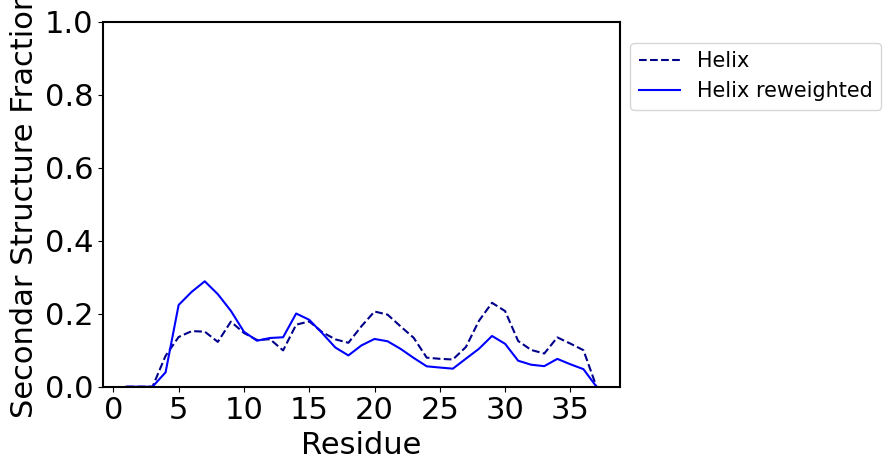

In [29]:
plt.clf()
plt.plot(prot_res_renum,Hprop,color='darkblue', label='Helix',linestyle='dashed')
plt.ylim(0,1.0)
plt.plot(prot_res_renum,reweight_Hprop,color='blue', label='Helix reweighted')

plt.xlabel('Residue', size=22)
plt.ylabel('Secondar Structure Fraction', size=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.85), fontsize=15)
plt.savefig('%s/SS.reweight.pdf'%outdir, bbox_inches='tight')

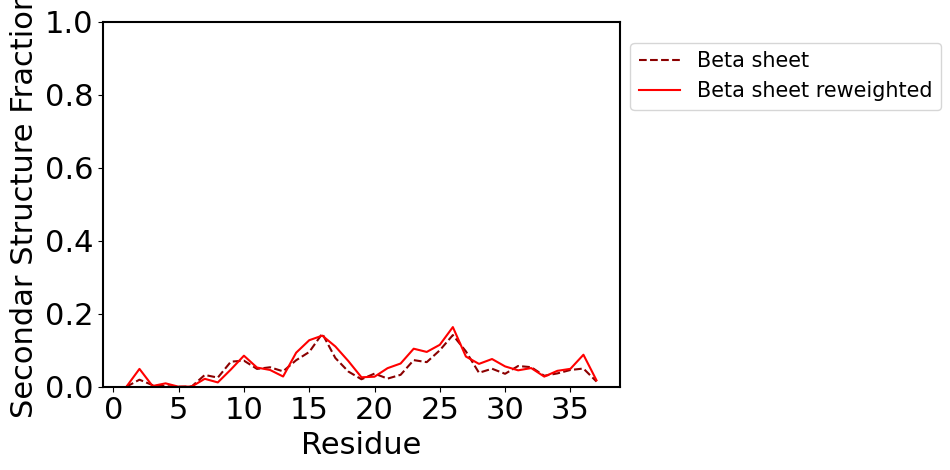

In [30]:
plt.plot(prot_res_renum,Eprop,color='darkred', label='Beta sheet',linestyle='dashed')
plt.plot(prot_res_renum,reweight_Eprop,color='red', label='Beta sheet reweighted')
plt.ylim(0,1.0)
plt.xlabel('Residue', size=22)
plt.ylabel('Secondar Structure Fraction', size=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.85), fontsize=15)
plt.savefig('%s/SS.reweight.pdf'%outdir, bbox_inches='tight')